In [1]:
from ava_functions import *

In [ ]:
## rigettando anche sulla base del ppp

In [2]:
import os
os.chdir('../../../Desktop/Criticality in barrel cortex')

In [3]:
from power import *
from powerlaw_fit import *
from stats import *


In [4]:
cd "../../Downloads/NewbornEEGData-20220203T094950Z-001/NewbornEEGData/"

C:\Users\Benedetta\Downloads\NewbornEEGData-20220203T094950Z-001\NewbornEEGData


In [19]:
#num: is the baby's number,
#sil: is the kind of silence,
#theta: is the threshold

#The trials of all babies in silence X are contained in the trial_silenceX folder where each column is a good channel series 

def autocorr_events(fl2, theta, interv):
    fl1 = np.array(fl2)/(np.std(np.array(fl2),0))
    t=np.arange(0,len(fl1)/500,0.002)
    
    #We convert the table to an array
    fl1 = np.asarray(fl1)
    spikes =np.array( [np.array(np.abs(fl1[:,i]) > theta, dtype=float) for i in range(len(fl1[0]))], dtype =int).T
    

    ev = events(spikes)
    N = spikes.shape[0]

    S_shape_ = np.zeros((N))
    for ch in range(spikes.shape[1]):
        S_shape_ += spikes[:,ch]
    where_spikes = np.where(S_shape_ != 0)
    interspike_time = (where_spikes - np.roll(where_spikes,1))
    interspike_time = np.delete(interspike_time,0) # remove the first element
    mean_interspike_time = np.sum(interspike_time)/len(interspike_time)
    mean_interspike_time = int(round(mean_interspike_time))
    #mean_interspike_time
    #print(mean_interspike_time)
    if len(ev)%interv > 0:

        add = (int(len(ev)/interv) + 1)* interv - len(ev)
        ev = ev.tolist()
        for i in range(add):
            ev = ev + [0]

    ev = np.asarray(ev).reshape(int(len(ev)/interv), interv)
    new = np.array(np.sum(ev,axis = 1),dtype = int)
    
    
    v = x_autocorr_sm(new)  


    return v['C'], v['tau']

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import powerlaw as pwl

## EEg autocorrelations (mean inter even to bin the data)

In [40]:
### COMPARISON BETWEEN SILENCE1 AND SILENCE2

import os
import numpy as np
import scipy.signal as ss
import scipy.io
#from dfa_functions import *
ch_names = ['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8']
ch_names = np.array(ch_names)
subjs  = [5,6,9,11,12,13,16,17,18,19,21,23,24,25,30,33,34,35,37,39,40,45,47,49,52,53,56,57,58,60,62,63,65,66,67,68,69,71,14,20,22,27,28,29,31,41,46,64,70]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.signal import welch
import pandas as pd
import mne


ch_names = np.array(ch_names)
sfreq = 500
info = mne.create_info(ch_names = list(ch_names),
                       ch_types = 'eeg',
                       sfreq = sfreq)
def find_bad_channels(data, MAX_PEAK=200, MAX_PEAK_SIGMA=15, MAX_DIST_PS=4.5e-3, OFFSET=30, fmin=1, fmax=100, 
                      verbose = True):
    idx_down, idx_up = 0, data.shape[1]
    ss = np.std(data)
    
    psds, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(data/1e6, info, verbose=False), fmin=fmin, fmax=fmax, n_fft=2048, n_overlap=1024/2, verbose=False)
    psds = np.log10(psds)
    
    dist = [((tmp-psds.mean(axis=0))**2).sum() for tmp in psds]
    dist = np.array(dist) / (psds**2).sum() * 1e2
    
    rej = []
    for i, ch in enumerate(ch_names):
        delta = np.abs(data[i]).max()
    
        str_rej = str()

        if delta>MAX_PEAK or dist[i]>MAX_DIST_PS:
            rej.append(ch)
            str_rej = '-> rejected'
            str_rej += ' ('
            if delta>MAX_PEAK:
                str_rej += ' peak'
                idx = np.where(np.abs(data[i])>MAX_PEAK)[0]
            
            if dist[i]>MAX_DIST_PS:
                str_rej += ' ps'
            str_rej += ')'
            
        if verbose: print(f'* {ch}: max peak = {np.round(delta, 2)} mV ({np.round(delta/ss, 2)} std); dist ps = {np.round(dist[i],3)} '+str_rej)
        
        if delta>MAX_PEAK:
            if np.max(idx)/sfreq<OFFSET:
                idx_down = np.max([np.max(idx),idx_down])
                if verbose: print(f'[*] WARNING: Peak only in the initial part - time: {np.max(idx)/sfreq} s')
            if np.min(idx)/sfreq>180-OFFSET:
                idx_up = np.min([np.min(idx),idx_up])
                if verbose: print(f'[*] WARNING: Peak only in the last part - time: {np.min(idx)/sfreq} s')
    if verbose: print('\nBad channels:', rej, '\n')
    return rej, idx_down, idx_up




In [41]:

cc = []
cc2 = []
interv = 10
for i, subj in enumerate(subjs):
    #print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    if nchan >= 5 and nchan2 >=5:
        
        
        #print('doing')
        c,tau = autocorr_events(data.T,2,interv)
        #print(len(c))
        cc.append(c)
        
        
        c,tau = autocorr_events(data2.T,2,interv)
        #print(len(c))
        cc2.append(c)
        

5
7
5
4
4
4
4
5
5
6
4
5
4
4
5
4
5
4
4
4
4
5
6
6
4
4
5
4
5
5
5
5
5
7
4
5
8
9
11
4
4
5
5
4
5
7
7
7
5
4
5
4
9
6
6
4
4
5
5
5
4
4
7
4
4
4


In [42]:
nn = min(list(map(len,cc)))
cc_arr = []
for i in cc:
    cc_arr.append(i[:nn])
cc_arr = np.asarray(cc_arr)


nn = min(list(map(len,cc2)))
cc2_arr = []
for i in cc2:
    cc2_arr.append(i[:nn])
cc2_arr = np.asarray(cc2_arr)

In [43]:
cc_arr.shape

(33, 3793)

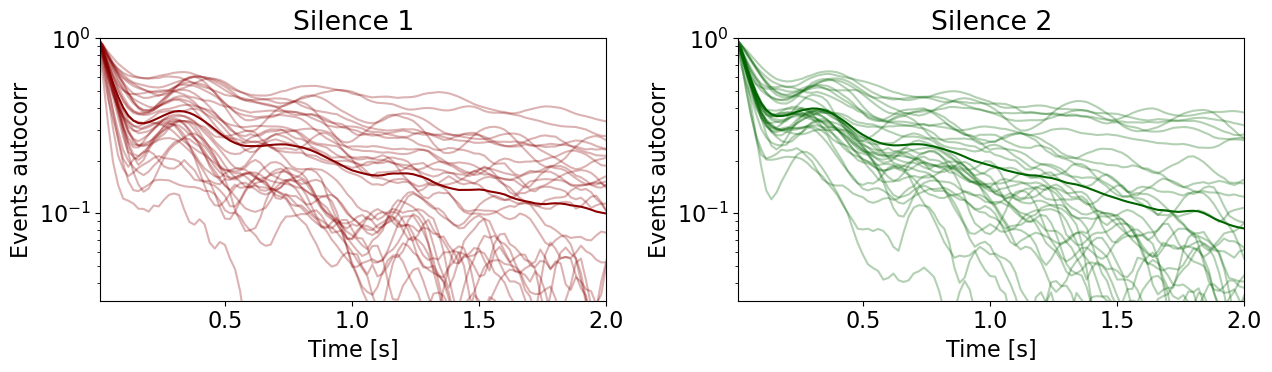

In [71]:

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (13,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
lags = np.arange(0,len(cc_arr[0]),1)*interv*0.002
for i in range(len(cc_arr)):
    ax1.plot(lags,cc_arr[i],color ='darkred', alpha = .3);
    
ax1.plot(np.arange(0,len(cc_arr[0]),1)*interv*0.002,np.mean(cc_arr,0),color ='darkred');
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Events autocorr')
ax1.set_title('Silence 1')
ax1.set_xlim(0.01,2)
ax1.set_ylim(10**-1.5,1)


lags = np.arange(0,len(cc2_arr[0]),1)*interv*0.002

for i in range(len(cc2_arr)):
    ax2.plot(lags,cc2_arr[i],color ='darkgreen', alpha = .3);
ax2.plot(lags,np.mean(cc2_arr,0), color ='darkgreen');
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Events autocorr')
ax2.set_title('Silence 2');
ax2.set_xlim(0.01,2)
ax2.set_ylim(10**-1.5,1);
plt.tight_layout();



In [68]:
cc2_arr.shape

(33, 2266)